In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
import matplotlib.pyplot as plt

from tqdm import tqdm

In [2]:
DEBUG = True
DEVICE = torch.device('cuda:0') if torch.cuda.is_available() and not DEBUG else 'cpu'

In [3]:
class CNNModel(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv2 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv3 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv4 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.conv5 = nn.Conv2d(1, 1, 5, padding=(2, 1), padding_mode="reflect")
        self.pool = nn.MaxPool1d(1, 3)
        self.sigmoid = nn.Sigmoid()
        self.to(device)


    def forward(self, x):
        dropped_one, n, d = x.shape
        x = x.reshape((1, 1, n, d))
        x = self.conv1(x)
        # print(x.shape)
        x = self.conv2(x)
        # print(x.shape)
        x = self.conv3(x)
        # print(x.shape)
        x = self.conv4(x)
        # print(x.shape)
        x = self.conv5(x)
        dopped_one_1, dropped_one_2, n, d = x.shape
        x = x.reshape((1, n, d))
        x = self.pool(x)
        # print(x.shape)
        x = self.sigmoid(x)
        return x

In [4]:
import DataImport
TRAIN_INPUT_FILE = "train.csv"
TEST_INPUT_FILE = "test.csv"
VAL_INPUT_FILE = "valid.csv"

x_train, y_train = DataImport.import_data(TRAIN_INPUT_FILE, DEVICE)
x_test, y_test = DataImport.import_data(TEST_INPUT_FILE, DEVICE)
x_val, y_val = DataImport.import_data(VAL_INPUT_FILE, DEVICE)
model = CNNModel()
print("input shape" + str(x_train.shape))
test_output = model(x_train)
print("output shape" + str(test_output.shape))
# print(test_output)

input shapetorch.Size([1, 70322, 13])
output shapetorch.Size([1, 70322, 1])


In [5]:
def train(model, x_train, y_train, n_epochs=5, lr=0.0001):
    optimizer = Adam(model.parameters(), lr=lr)
    criterion = nn.BCELoss()

    losses = []
    for epoch in tqdm(range(n_epochs)):
        optimizer.zero_grad()

        output_train = model(x_train)
        output_train = output_train.reshape((output_train.shape[1], output_train.shape[2]))
        # print(output_train)
        loss_train = criterion(output_train, y_train)
        loss_train.backward()
        optimizer.step()
        loss_value = loss_train.item()
        losses.append(loss_value)
        if epoch % 100 == 0:
            print("Epoch {}: loss = {}".format(str(epoch), str(loss_value)))

        if len(output_train.nonzero()) == 0:        # not sure if this works
            print("Epoch {}: all zero output!".format(str(epoch)))

    return losses

def calc_acc(y_pred, y, th=0.52):
    #tp = 0
    #tn = 0
    size = len(y)
    #for i in range(size):
    #    if y_pred[i] >= th and y[i] == 1:
    #        tp += 1
    #    elif y_pred[i] < th and y[i] == 0:
    #        tn += 1
    #return float(tp + tn)*100/size
    with torch.no_grad():
        #print(y)
        #print(y_pred)
        y_th = torch.heaviside(y_pred - torch.tensor(th).expand_as(y_pred), torch.tensor(1.0).expand_as(y_pred))
        tp = torch.sum(torch.logical_and(y_th, y))
        p_pred = torch.sum(y_th)
        p_label = torch.sum(y)
        #print(y_th)
        #print(torch.logical_xor(y_th, y))
        acc = float(size - torch.sum(torch.logical_xor(y_th, y)))*100/size
        prec = float(tp)*100/p_pred
        rec = float(tp)*100/p_label
    return [acc, prec, rec]

In [6]:
model = CNNModel(DEVICE)
losses = train(model, x_train, y_train, n_epochs=100, lr=0.001)

  1%|          | 1/100 [00:00<00:50,  1.96it/s]

Epoch 0: loss = 0.8854621648788452


100%|██████████| 100/100 [00:44<00:00,  2.23it/s]


Text(0, 0.5, 'Loss')

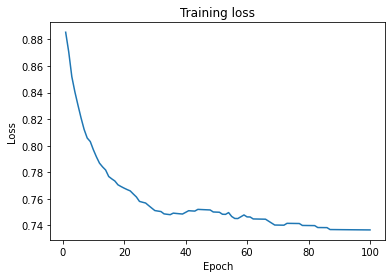

In [7]:
# print(losses)
# plot
plot_x = np.arange(1, 101)
plot_y = np.array(losses)
plt.plot(plot_x, plot_y)
plt.title("Training loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

In [8]:
print("Hyperparameter tuning")
best_th = 0.0
best_acc = 0.0
with torch.no_grad():
    for i in range(100):
        th = i / 100.0
        y_prediction = model(x_val)
        y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
        evauluation_result = calc_acc(y_prediction, y_val, th=th)
        accuracy = evauluation_result[0]
        if accuracy > best_acc:
            best_acc = accuracy
            best_th = th
    print("best threshold:" + str(best_th))
    print(best_acc)

Hyperparameter tuning
best threshold:0.5
52.36455696202532


In [9]:
print("Evaluate on training data with best threshold")
with torch.no_grad():
    y_prediction = model(x_train)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_train)
    print(evauluation_result)

Evaluate on training data with best threshold
[52.46295611615142, tensor(55.9459), tensor(38.6959)]


In [10]:
# confusion matrix
# Confusion Matrix on submission_model_XX
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(tp, fp, fn, tn):
    """
    Plots a confusion matrix using the values
       tp - True Positive
       fp - False Positive
       fn - False Negative
       tn - True Negative
    """
    data = np.matrix([[tp, fp], [fn, tn]])

    sns.heatmap(data,annot=True,xticklabels=['Actual Pos', 'Actual Neg']
              ,yticklabels=['Pred. Pos', 'Pred. Neg'])

def plot_model(model_name, predictions, labels):
    y_true = labels
    y_pred = predictions
    x = confusion_matrix(y_true, y_pred)
    tp = x[1][1]
    fp = x[0][1]
    tn = x[0][0]
    fn = x[1][0]
    ax= plt.subplot()
    plot_confusion_matrix(tp=tp, fp=fp, tn=tn, fn=fn)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix' + model_name)

with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction_confusion = y_prediction.reshape(y_prediction.shape[1])
    y_th = torch.heaviside(y_prediction_confusion
                           - torch.tensor(best_th).expand_as(y_prediction_confusion),
                           torch.tensor(1.0).expand_as(y_prediction_confusion))
    y_test_confusion = y_test.reshape(y_test.shape[0])
    plot_model("", y_th, y_test_confusion)

ModuleNotFoundError: No module named 'seaborn'

In [11]:
print("Evaluate on testing data with best threshold")
with torch.no_grad():
    y_prediction = model(x_test)
    y_prediction = y_prediction.reshape((y_prediction.shape[1], y_prediction.shape[2]))
    evauluation_result = calc_acc(y_prediction, y_test, th=best_th)
    print(evauluation_result)

Evaluate on testing data with best threshold
[52.13850897304135, tensor(52.0168), tensor(26.0884)]
